Лабораторная 8

Записки по ПМУ (кластеризация, антиплагиат)

In [34]:
import spacy
import num2words
import re
import unicodedata
import pandas as pd
from docx import Document
import os

sp = spacy.load("ru_core_news_lg")

def read_docx(file_path):
    try:
        doc = Document(file_path)
        full_text = []
        for paragraph in doc.paragraphs:
            full_text.append(paragraph.text)
        return "\n".join(full_text)
    except Exception as e:
        print(f"Файл {file_path} не подходит формату: {e}")
        return ""
def load_docs(dataset_path):
    df = pd.DataFrame(columns=["doc", "text"])
    for file_path in os.listdir(dataset_path):
        if file_path.startswith("~$"):
            continue
        text = read_docx(dataset_path + file_path)
        df.loc[len(df.index)] = [file_path, text]
    return df


df = load_docs("pmu/")
df["type"] = df.apply(
    lambda row: 0 if str(row["doc"]).startswith("tz_") else 1, axis=1
)
df.info()
df.sort_values(by=["doc"], inplace=True)

Файл pmu/31-МасенькинМС.pdf не подходит формату: Package not found at 'pmu/31-МасенькинМС.pdf'
Файл pmu/31-РазубаевСМ (1).pdf не подходит формату: Package not found at 'pmu/31-РазубаевСМ (1).pdf'
Файл pmu/31-ТерёхинАС.doc не подходит формату: Package not found at 'pmu/31-ТерёхинАС.doc'
Файл pmu/31-ШаныгинАВ (1).doc не подходит формату: Package not found at 'pmu/31-ШаныгинАВ (1).doc'
Файл pmu/32-КозловаАА (1).doc не подходит формату: Package not found at 'pmu/32-КозловаАА (1).doc'
Файл pmu/32-КозловаАА.doc не подходит формату: Package not found at 'pmu/32-КозловаАА.doc'
Файл pmu/32-ПучкинаАА (1).doc не подходит формату: Package not found at 'pmu/32-ПучкинаАА (1).doc'
Файл pmu/32-ПучкинаАА.doc не подходит формату: Package not found at 'pmu/32-ПучкинаАА.doc'
Файл pmu/32-СмирновАА.doc не подходит формату: Package not found at 'pmu/32-СмирновАА.doc'
Файл pmu/32-ЧубыкинаПП (1).doc не подходит формату: Package not found at 'pmu/32-ЧубыкинаПП (1).doc'
Файл pmu/32-ЧубыкинаПП.doc не подходит фор

Предобработка

In [35]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Zа-яА-Я ]", "", text)

    text = unicodedata.normalize("NFKD", text)
    text = "".join([char for char in text if not unicodedata.combining(char)])

    words: list[str] = text.split()
    words = [num2words(word, lang="ru") if word.isdigit() else word for word in words]
    text = " ".join(words)
    doc = sp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

df["preprocessed_text"] = df["text"].apply(preprocess_text)

Выделение частей речи

In [36]:
def morphological_analysis(text: str) -> list[dict]:
    doc = sp(text)
    tokens_info = [
        {
            "text": token.text,
            "pos": token.pos_,
            "morph": token.morph,
        }
        for token in doc
    ]
    return tokens_info

#df["pos_tagging_text"] = df["preprocessed_text"].apply(morphological_analysis)
#print(df.head)

Нормализация текста(Лемматизация)

In [37]:
from spacy.tokens.doc import Doc


def lemmatize_text(text: str) -> str:
    doc = sp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

df["normalized_text"] = df["preprocessed_text"].apply(lemmatize_text)

Фильтрация(длина от 5 до 15 символов)

In [38]:
def filter_text(text: str, min_length: int = 5, max_length: int = 15) -> str:
    words = text.split()
    filtered_words = [
        word for word in words 
        if min_length <= len(word) <= max_length
    ]
    return " ".join(filtered_words)

df["filtered_text"] = df["normalized_text"].apply(filter_text)

Создание нечеткой системы и добавление нечетких правил в базу знаний нечеткой системы

In [39]:
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def generate_ngrams(text: str, n: int = 2) -> list[tuple]:
    tokens = word_tokenize(text, language="russian")
    n_grams: list[tuple] = list(ngrams(tokens, n))
    return n_grams

df["trigrams"] = df["filtered_text"].apply(lambda x: generate_ngrams(x, n=3))

Векторизация. Метод мешков

In [40]:
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer

counts_vectorizer = CountVectorizer()
counts_matrix = sparse.csr_matrix(counts_vectorizer.fit_transform(df["filtered_text"]))
counts_df = pd.DataFrame(
    counts_matrix.toarray(),
    columns=counts_vectorizer.get_feature_names_out(),
)

Векторизаций. Частотный портрет

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_matrix = sparse.csr_matrix(tfidf_vectorizer.fit_transform(df["filtered_text"]))
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
)

Метод локтя

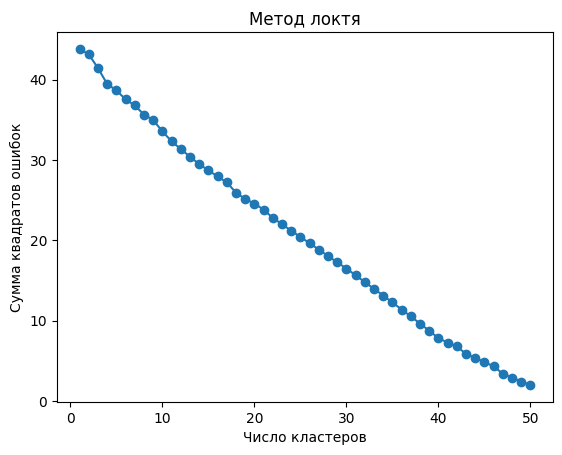

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 51):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 51), wcss, marker='o')
plt.title('Метод локтя')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов ошибок')
plt.show()

Коэффициент силуэта

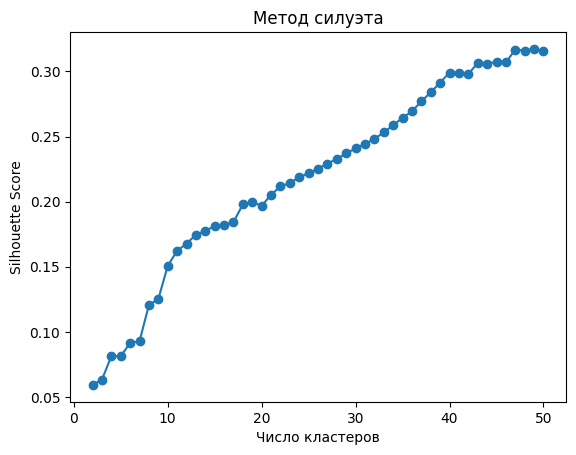

In [43]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 51): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_, random_state=42)
    silhouette_scores.append(score)
    #print(f"Число кластеров: {i}, Коэффициент силуэта: {score:.4f}")

plt.plot(range(2, 51), silhouette_scores, marker='o')
plt.title('Метод силуэта')
plt.xlabel('Число кластеров')
plt.ylabel('Silhouette Score')
plt.show()

Кластеризация с использованием Kmeans

In [44]:
from sklearn.cluster import KMeans


n_clusters = 40
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
df["cluster"] = kmeans.labels_
display(df[["doc", "cluster"]])

doc  cluster
0                             31-АнисинРС.docx       15
1                          31-АфанасьевСС.docx        2
2                         31-БакальскаяЕД.docx       12
3                           31-БарсуковПО.docx       20
4                            31-БелянинНН.docx       14
..                                         ...      ...
69     Курсовая ПМУ Волков Никита ПИбд-33.docx        7
70  ПИбд-31, Лёвушкина Анна, записка к кр.docx       10
71                   ПИбд-32 Шабунов Олег.docx        1
72              Фирсов_Кирилл_Записка (1).docx        3
73                  Фирсов_Кирилл_Записка.docx        3

[74 rows x 2 columns]

Визуализация с помощь PCA

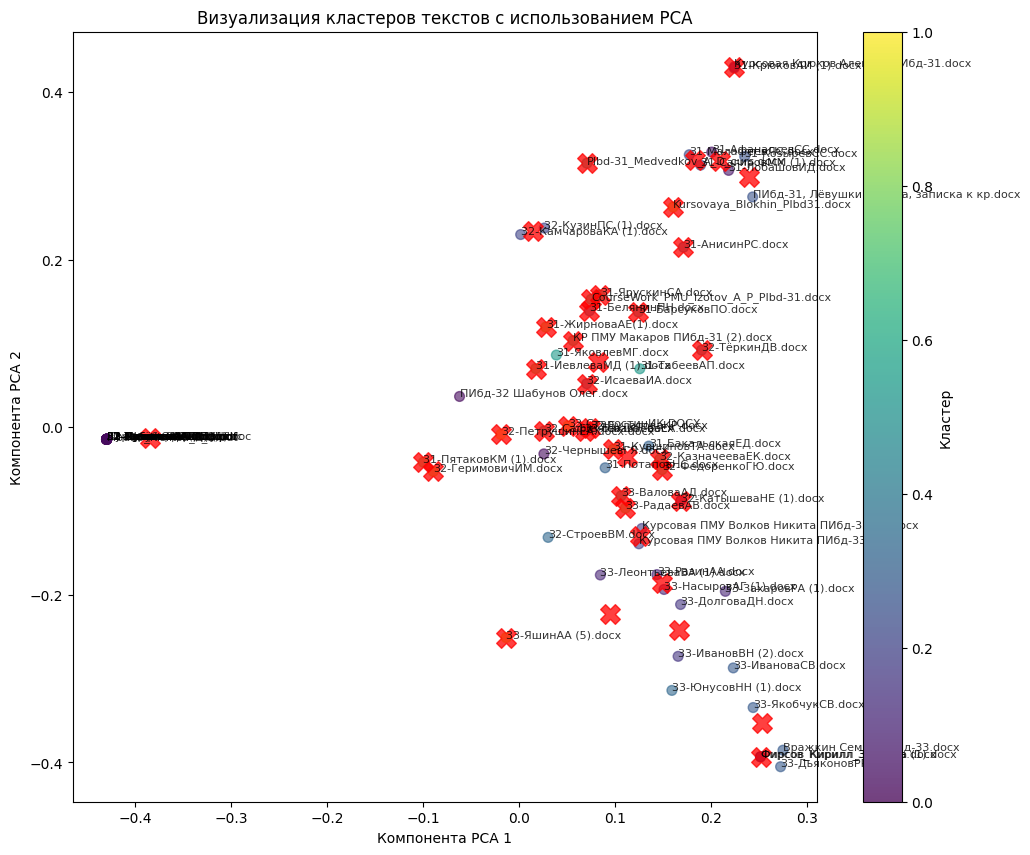

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_clusters = 40
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_matrix.toarray())

# 
plt.figure(figsize=(12, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis", s=50, alpha=0.6)


centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c="red", s=200, alpha=0.75, marker="X")

for i, doc in enumerate(df["doc"]):
    plt.text(X_pca[i, 0], X_pca[i, 1], doc, fontsize=8, alpha=0.8)

plt.title("Визуализация кластеров текстов с использованием PCA")
plt.xlabel("Компонента PCA 1")
plt.ylabel("Компонента PCA 2")
plt.colorbar(label="Кластер")
plt.show()